# Sampling from the von Mises Distribution  

In this notebook we implement functions to calculate and sample from the von Mises distribution [1]. Moreover, we also implement a few simple functions to visualise circular distributions. Strictly speaking one does not need to write their own implementation for calculating the von-Mises probability density function or sampling from it, as it is available in the [scipy statistics package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.vonmises.html).  Numpy also has an implementation as well, which can be found [here](https://numpy.org/doc/1.16/reference/generated/numpy.random.vonmises.html). However, it is quite easy to write your own implementation (see Refs. [2,3]). However, these libraries don't implement many other functions related to field of directional statistics. 


## Introduction 

The von Mises distribution was introduced by Richard von Mises in 1918 [1]. Its probability density function is defined as
\begin{equation}
p(\theta; \kappa, \mu) \equiv \frac{1}{2\pi I_{0}(\kappa)} \exp\left( \kappa \left[ \theta - \mu \right] \right)\  ,
\end{equation}
where $\theta$ is the random angular variable, $\mu$ is the mean direction such that$-\pi\leq \theta , \mu < \pi$, $\kappa$ is a measure of the 
concentration of the probability density function and lies in the semi-infinite interval $0\leq \kappa < \infty$. Stricyly speaking the range of $\theta$ and $\mu$ can be any interval of length $2\pi$. The larger the concentration, the more concentrated it is about the mean direction.The function 
$I_{\nu}(\kappa)$ is the modified Bessel function of the first kind,
\begin{equation}
I_{\nu}(\kappa) \equiv \frac{1}{\pi} \int_{0}^{\pi} \exp\left( \kappa \cos\theta \right) \cos\left(\nu\theta\right) d\theta \  .
\end{equation} 

Angular random variables are more naturally modelled using circular distributions rather than the almost ubiquitous use of normal distributions. They are more natural  for a number of reasons, a few of which we will now briefly mention:


- The von Mises distribution is defined on the correct sample space whereas the normal distribution is not bounded to the interval of length $2\pi$, e.g., $[-\pi,\pi)$ or $[0,2\pi)$. The normal distribution can be a good approximation away from the boundaries. However, its use can lead to issues near the boundaries.

- The von Mises distribution has the correct limiting behaviour as $\kappa\to 0$ whereas the normal distribution does not. The von Mises distribution approaches the uniform distribution on the unit circle in this limit, so that all directions are equally likely.

- Naive use of normal distributions for circular problems can lead to the incorrect fusion of the prior with the measurement likelihood. Therefore, for example, if you were performing angle of arrival measurements in a tracking application you may be incorrectly fusing measurements when performing a Bayesian update.


As the von Mises distribution can be considered a distribution on the unit circle $\mathbb{S}^{1}$, one can identify the angle $\theta$ with the unit phasor $e^{i\theta}$ and the mean direction of the circular random variable $\alpha$ can be computed as follows
\begin{eqnarray}
\mathbb{E}[\alpha] & = & \angle \int_{-\pi}^{\pi} e^{i\theta} p(\theta; \mu, \kappa) d\theta \nonumber\\
& = & \angle \frac{1}{2\pi I_{0}(\kappa)} \int_{-\pi}^{\pi} e^{i\theta} e^{\kappa \cos(\theta -\mu)} d\theta \nonumber\\
& = & \angle \frac{1}{2\pi I_{0}(\kappa)} \int_{-\pi}^{\pi} e^{i(\theta+\mu)} e^{\kappa \cos\theta} d\theta \nonumber\\
& = & \angle \frac{e^{i\mu}}{2\pi I_{0}(\kappa)} \int_{-\pi}^{\pi} e^{i\theta} e^{\kappa \cos\theta} d\theta \nonumber\\
& = & \angle \frac{e^{i\mu}}{2\pi I_{0}(\kappa)} \int_{-\pi}^{\pi} \left[\cos\theta + i \sin\theta \right]e^{\kappa \cos\theta} d\theta \nonumber\\
& = & \angle \frac{e^{i\mu}}{2\pi I_{0}(\kappa)} \int_{-\pi}^{\pi} \cos\theta e^{\kappa \cos\theta} d\theta \nonumber\\
& = & \angle \frac{e^{i\mu}}{\pi I_{0}(\kappa)} \int_{0}^{\pi} \cos\theta e^{\kappa \cos\theta} d\theta \nonumber\\
& = & \angle e^{i\mu} \frac{I_{1}(\kappa)}{I_{0}(\kappa)} \nonumber \\
& = & \mu \   ,
\end{eqnarray}
where $\angle$ refers to the phase (or angle). The angular distance between two phases can be written as 
\begin{equation}
d( e^{i\theta},e^{i\varphi} )  = \vert (\theta - \varphi)\ \ (\, \textrm{mod}\, 2\pi\, )\vert \   ,
\end{equation}
which allows us to calculate the variance of the circular random variable $\alpha$
\begin{eqnarray}
\sigma_{\alpha}^{2} & \equiv &\mathbb{E}\left[\left( d( e^{i\theta},e^{i\mu} ) \right)^{2}\right] \nonumber\\
& = &  \int_{-\pi}^{\pi}  \vert (\theta - \mu)\ \ (\,\textrm{mod}\, 2\pi\, )\vert^{2} p(\theta;\mu,\kappa) d\theta  \nonumber\\
& = &  \frac{1}{2\pi I_{0}(\kappa)} \int_{-\pi}^{\pi}  \vert (\theta - \mu)\ \ (\, \textrm{mod}\, 2\pi\, )\vert^{2}e^{\kappa \cos(\theta -\mu)}d\theta  \nonumber\\
& = &  \frac{1}{2\pi I_{0}(\kappa)} \int_{-\pi}^{\pi}  \theta^{2}e^{\kappa \cos\theta }d\theta  \nonumber\\
& = & \frac{1}{\pi I_{0}(\kappa)} \int_{0}^{\pi}  \theta^{2}e^{\kappa \cos\theta }d\theta  \  .
\label{eq:VMvar1}
\end{eqnarray}

The input parameters for the von Mises distribution are the mean direction and the concentration whereas experimental error is commonly given in terms of a variance.
Fortunately, it is possible to show that the variance is approximately inversely proportional to the concentration, thus allowing us a way to estimate the concentration  using the variance. We rewrite the equation above as 
\begin{eqnarray}
\frac{1}{\pi I_{0}(\kappa)} \int_{0}^{\pi}  \theta^{2}e^{\kappa \cos\theta }d\theta
& = & \frac{1}{\pi I_{0}(\kappa)} \int_{0}^{\pi}  \theta^{2}\left(- \frac{1}{\kappa\sin\theta}\right)\frac{d}{d\theta}\left( e^{\kappa \cos\theta }\right) d\theta 
\end{eqnarray}
and we use the expansion for the cosecant function 
\begin{eqnarray}
\frac{1}{\sin x} & = & \sum_{n=0}^{\infty} \frac{(-1)^{n+1}2(2^{2n-1}-1)B_{2n}x^{2n-1}}{(2n)!}  \\
& = & \frac{1}{x} + \frac{x}{6} + \frac{7}{360}x^{3} +\frac{31}{15120}x^{5} + \ldots \ ,
\end{eqnarray}
where the $B_{2n}$ are the Bernoulli numbers. This series converges for $0< \vert x\vert <\pi$. If we keep only the first term
\begin{eqnarray}
\frac{1}{\pi I_{0}(\kappa)} \int_{0}^{\pi}  \theta^{2}   \left(- \frac{1}{\kappa\sin\theta}\right)\frac{d}{d\theta}\left( e^{\kappa \cos\theta }\right) d\theta & &   \nonumber\\
& \sim &  \frac{1}{\pi I_{0}(\kappa)} \int_{0}^{\pi}  \theta^{2}\left(- \frac{1}{\kappa\theta}\right)\frac{d}{d\theta}\left( e^{\kappa \cos\theta }\right) d\theta + \ldots\nonumber\\
& = & -\frac{1}{\kappa \pi I_{0}(\kappa)}  \int_{0}^{\pi} \theta \frac{d}{d\theta}  \left( e^{\kappa\cos\theta} \right) d\theta + \ldots \nonumber\\
& = & -\frac{1}{\kappa \pi I_{0}(\kappa)} \left[ - \int_{0}^{\pi} e^{\kappa\cos\theta} d\theta + \left.\theta e^{\kappa\cos\theta}\right\vert_{0}^{\pi} \right]+ \ldots \nonumber\\
& = & -\frac{1}{\kappa \pi I_{0}(\kappa)} \left[ - \pi I_{0}(\kappa) + \pi e^{-\kappa} \right]+ \ldots \nonumber\\
& = & \frac{1}{\kappa} - \frac{1}{\kappa I_{0}(\kappa)} e^{-\kappa} + \ldots \ .
\end{eqnarray}
One should note that while the regular Bessel functions are oscillatory, the modified Bessel functions are not. The modified Bessel functions of the first kind $I_{n}(\kappa)$ grow exponentially fast with $\kappa$. Since the second term is divided by $I_{0}(\kappa)$ the approximation
$\sigma_{\alpha}^{2} \simeq  1/\kappa$ should be reasonable provided $\kappa$ is large enough. Vice versa if we have an empirically determined variance we could approximate the concentration by $1/\sigma_{\alpha}^{2}$.



In this notebook we will be making use of the algorithm by Best and Fisher to sample the von-Mises distribution. This algorithm only requires sampling of a uniform distribution on $[0,1]$ and using some trignometric and logarithmic  functions [2].



## Implementation

### Imports 

In [1]:
from scipy.special import iv # Bessel function of the first kind
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d

### Probability Density Function (PDF)

Documentation for the Bessel function of the first kind can be found  [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.iv.html#scipy.special.iv) under the [scipy special functions section.](https://docs.scipy.org/doc/scipy/reference/special.html) 


In [2]:
def pdf_von_Mises(theta,mu,kappa):
    """
        pdf_von_Mises(theta,mu,kappa)
        =============================
        
        Calculates the von Mises probability density distribution at the angle theta with mean
        direction mu and concentration kappa.

        INPUT:

            * theta - angle at which to evaluate the von Mises distribution (float or numpy array)
            * mu - mean direction (float)
            * kappa - concentration (float)

        OUTPUT:

             * pdf - the probability density function is an Nx1 (same size as theta) array of values of a von Mises
             distribution with mean direction mu and concentration kappa.

        References:
        ===========

        See the following textbook/monograph

        [1] N. I. Fisher, Statistical analysis of circular data, Cambridge University Press, (1993).

    """ 
    
    pdf = np.exp(kappa * np.cos(theta - mu)) / (2.0*np.pi*iv(0,kappa));

    return pdf

### Sampling

In [3]:
def rand_von_Mises(N,mu,kappa):

    """
        rand_von_Mises(N,mu,kappa)
        ==========================
        
        Generates theta an Nx1 array of samples of a von Mises distribution
        with mean direction mu and concentration kappa.

        INPUT:
         
            * N - number of samples to be generated (integer)
            * mu - mean direction (float)
            * kappa - concentration (float)

        OUTPUT:
         
            * theta - an Nx1 array of samples of a von Mises distribution with mean 
            direction mu and concentration kappa.

         References:
         ===========

         Algorithm first given in

         [1] D. J. Best and N. I. Fisher, Efficient Simulation of the von Mises
         Distribution, Applied Statistics, 28, 2, 152--157, (1979).

         Also given in the following textbook/monograph

         [2] N. I. Fisher, Statistical analysis of circular data, Cambridge University Press, (1993).

    """
    
    # Checks 
    # =======

    # N should be a positive non-zero integer scalar 
    if (type(N) is not int): 
        raise TypeError("N must be a positive non-zero integer.")
    if N <= 0:
        raise Exception("N must be a positive non-zero integer.")
        
    #  mu should be a real scalar. It can wrap around the circle, so it can be negative, positive and also 
    #  outside the range [0,2*pi].
    if (type(mu) is not float) and (type(mu) is not int):
        raise TypeError("mu must be a real scalar number.")

    # kappa should be positive real scalar 
    if (type(kappa) is not float) and (type(kappa) is not int): 
        raise TypeError("kappa must be a positive float.")
    if kappa < 0:
        raise Exception("kappa must be a positive float.")

    #  SPECIAL CASE
    # ==============

    #  As kappa -> 0 one obtains the uniform distribution on the circle
    float_epsilon = np.finfo(float).eps
    if kappa <= float_epsilon:
        theta = 2.0 * np.pi * np.random.rand(N,1) # [0,1] -> [0,2*pi]
        return theta

    # MAIN BODY OF ALGORITHM
    # =======================
    
    # Used same notation as Ref.~[2], p49
    
    a = 1.0 + np.sqrt(1.0 + 4.0 * kappa**2)
    b = (a - np.sqrt(2.0 * a)) / (2.0 * kappa)
    r = (1.0 + b**2) / (2.0 * b)

    counter = 0 
    theta = np.zeros((N,1)) 

    while counter <= N-1:
        
        # Pseudo-random numbers sampled from a uniform distribution [0,1]
        U1 = np.random.rand()
        U2 = np.random.rand()
        U3 = np.random.rand() 
        
        z = np.cos(np.pi * U1)
        f = (1.0 + r *z) / (r + z)
        c = kappa * (r - f)
        
        if ( ((c * (2.0 - c) - U2) > 0.0)  or ((np.log(c/U2) + 1.0 - c) > 0.0) ):
        
            theta[counter] = np.mod(np.sign(U3 - 0.5) * np.arccos(f) + mu, 2*np.pi)     
            counter += 1

    return theta

In [4]:
theta = rand_von_Mises(5,2,3)
print(theta)

[[2.65622723]
 [0.70913402]
 [2.06468918]
 [1.81297093]
 [1.34114562]]


### Visualisation

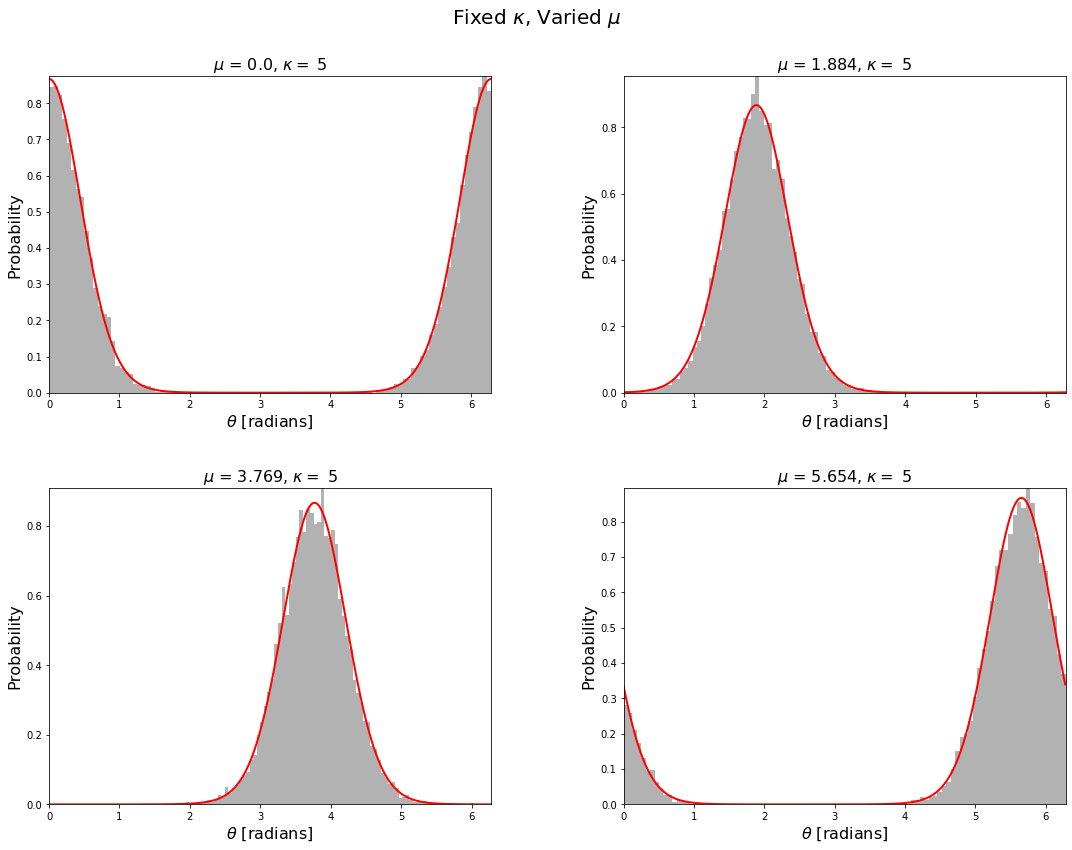

In [5]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
axes = axes.flatten()

# Number of samples 
N = 10000

# Number of bins
nbins = 100

# Fix kappa
kappa = 5

# Vary mu 
means = [ (x * np.pi * 0.6) for x in range(4) ] 

# Full range of theta for calculating the pdf 
t = np.linspace(0,2*np.pi,1000, endpoint=False)

for i in range(4):
    
    # Probability density line
    pdf = pdf_von_Mises(t,means[i],kappa)
    
    # von-Mises samples
    t_samples = rand_von_Mises(N,means[i],kappa)
    
    # Plot histogram 
    axes[i].hist(t_samples,bins=nbins,density=True,alpha=0.3,color='black');
    
    # Plot PDF
    axes[i].plot(t,pdf,color='red',lw=2);
    
    # Layout and labels
    axes[i].autoscale(tight=True)
    axes[i].set_title('$\mu$ = '+ str(means[i])[:5] + ", " + '$\kappa = $ '+ str(kappa),fontsize=16)
    axes[i].set_xlabel(r'$\theta$ [radians]',fontsize=16)
    axes[i].set_ylabel('Probability',fontsize=16)
    
# More layout and labels
fig.suptitle('Fixed $\kappa$, Varied $\mu$',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Save it
plt.savefig("vm-fix-k-vary-mu.png")

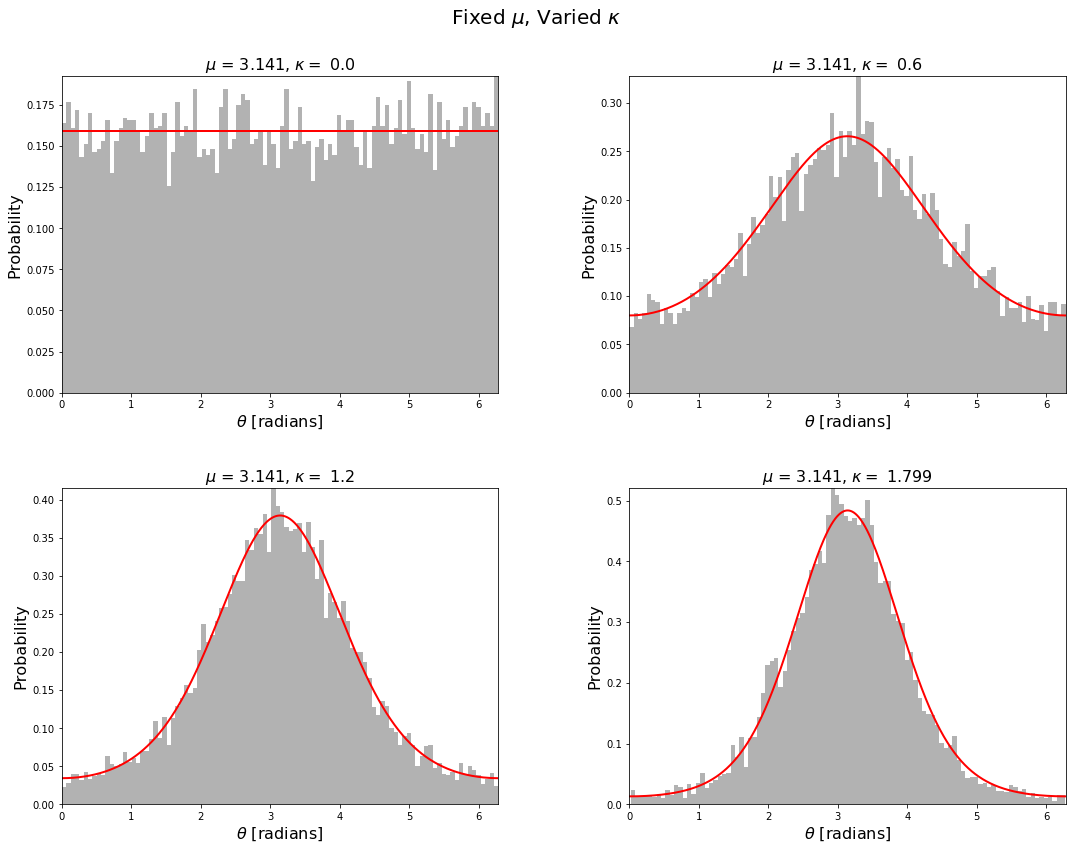

In [6]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
axes = axes.flatten()

# Number of samples 
N = 10000

# Number of bins
nbins = 100

# Vary kappa
kappas = [x*0.6 for x in range(4)]

# fix mu 
mu = np.pi

for i in range(4):
    
    # Probability density line
    pdf = pdf_von_Mises(t,mu,kappas[i])
    
    # von-Mises samples
    t_samples = rand_von_Mises(N,mu,kappas[i])
    
    # Plot histogram 
    axes[i].hist(t_samples,bins=nbins,density=True,alpha=0.3,color='black');
    
    # Plot PDF
    axes[i].plot(t,pdf,color='red',lw=2);
    
    # Layout and labels
    axes[i].autoscale(tight=True)
    axes[i].set_title('$\mu$ = '+ str(mu)[:5] + ", " + '$\kappa = $ '+ str(kappas[i])[:5],fontsize=16)
    axes[i].set_xlabel(r'$\theta$ [radians]',fontsize=16)
    axes[i].set_ylabel('Probability',fontsize=16)
    
# More layout and labels
fig.suptitle('Fixed $\mu$, Varied $\kappa$',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Save it
plt.savefig("vm-fix-mu-vary-k.png")

In [7]:
def polar2cartesian(r,theta):
    
    """
        polar22cartesian(r,theta)
        =========================
    
        This function converts polar coordinates to cartesian coordinates. Note that 
        we allow r to be scalar, it will broadcast to the correct size if theta is 
        an array.
        
        INPUT: 
        
            * r - radial coordinate - float scalar or array the same size as theta. 
            * theta - angular coordinate - float scalar or array.
        
        OUTPUT: 
        
            * x, y - Cartesian coordinates - these are arrays of floats the same size as theta.
        
    """
    
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    return x,y
    

In [8]:
def get_label_colours(labels):
    
    """
        get_label_colours(labels)
        =========================

        Creates an array of distinct colours for the distinct classes in the array labels. This 
        array is the same size as labels. 
        
        INPUT: 
        
            * labels - an array of labels. 
            
        OUTPUT: 
        
            * colours - an array of colours of the same size as labels with distinct colours for 
            distinct classes in labels.
    """
    
    # Assigns a unique colour to each distinct label. A dictionary is returned from distinct_colours() 
    # with keys equal to the distinct classes in labels and the values are the distinct colours.
    dic = distinct_colours(labels)
        
    # Create an array of the same length as labels containing distinct colours for each distinct label   
    colours = [dic[l] for l in labels]

    return colours

In [9]:
def distinct_colours(labels):
    
    """
        distinct_colours(labels)
        ========================
        
        INPUT: 
        
            * labels - an array of labels. 
            
        OUTPUT: 
        
            * dic - a dictionary with keys equal to the distinct classes in
            labels and the values are the distinct colours.
            
        NOTES: requires "from collections import Counter"
          
    """
    
    # keys = labels, values = counts
    dic = dict(Counter(labels)) 
    
    # list of distinct labels
    distinct_labels = list(dic.keys()) 
    
    # number of distinct labels 
    num_labels = len(distinct_labels) 
    
    # distinct colours, length is num_labels
    distinct_colours = cm.rainbow(np.linspace(0, 1, num_labels)) 
    
    # Replace counts with colours in the dictionary
    for i,l in enumerate(dic): 
        dic[l] = distinct_colours[i] 
    
    return dic

In [10]:
def plot_angular_scatter(samples,labels=None,ms=100):
    
    """
        plot_angular_scatter(samples,labels=None,ms=100)
        ================================================
        
        Creates a scatter plot on a circle of samples from a circular distribution. 
        
        INPUT: 
        
            * samples - samples of a circular distribution - either a scalar or array of floats.
            * labels - an optional argument containing class labels, default is None. 
            * ms - an optional argument markersize, default is 100.
            
        OUTPUT: 
        
            * Scatter plot on a circle of samples from a circular distribution.
            * ax (axes) - axes on which the plot is constructed.
    
    """
    
    # Plot the unit circle S^{1}
    # ==========================
    
    # Radius
    r = 1.0
    
    # Angular grid 
    theta = np.linspace(0,2*np.pi,500, endpoint=False)
    
    # Convert polar coordinates to cartesian coordinates
    [x,y] = polar2cartesian(r,theta)
    
    # Plot the circle 
    plt.plot(x,y,color='black',lw=2,zorder=0) # zorder=0 puts the circle behind all the data
    
    # Make aspect square
    ax = plt.gca() 
    ax.set_aspect('equal')
    
    # Make the scatter plot of samples 
    # ================================
    
    # Convert polar coordinates to cartesian coordinates
    [xi,yi] = polar2cartesian(r,samples)
    
    if labels is None:
        
        # if there are no labels plot every point a different colour
        colors = cm.rainbow(np.linspace(0, 1, len(xi)))
        scatter = plt.scatter(xi,yi,color=colors,label=labels)
        
    else:
        
        # if labels are given create a dictionary were the keys are 
        # the distinct labels and the values are distinct colours
        dic = distinct_colours(labels)        
        
        # Loop over each distinct class (label)
        for k in dic.keys():
            
            # Get indices for this distinct class
            indices = [i for i, l in enumerate(labels) if l == k]
            
            # Get coordinates for this distinct class
            x = [xi[i] for i in indices]
            y = [yi[i] for i in indices]
            
            # Plot this class
            plt.scatter(x,y,color=dic[k],label=k,s=ms)   
        
        # Turn axes off
        ax = plt.gca()
        ax.axis('off')  
        
    return ax 

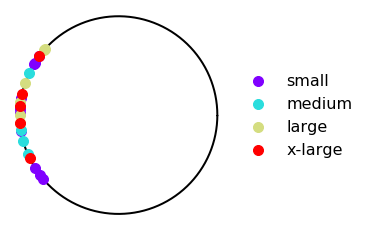

In [11]:
# Mock data 
t_samples = rand_von_Mises(25,mu,kappa=5)
labels = ['small']*10 + ['medium']*4 + ['large']*6 + ['x-large']*5

# Plot the angular scatter plot
fig = plt.figure(figsize=(8,4))
plot_angular_scatter(t_samples,labels)

# Legend
plt.legend(frameon=False,loc="center left", bbox_to_anchor=(1,0.5), ncol=1,  fontsize=16)

# Save it
plt.savefig("vm-ang-scatter.png")

In [12]:
def plot_angular_density(theta,pdf,colour="blue",maxline=False,axes="off",fs=16):
    
    """
        plot_angular_density(theta,pdf,colour="blue",maxline=False,axes="off",fs=16)
        ============================================================================
        
        Plots the probability density function of a circular distribution on the unit 
        circle.
        
        INPUT: 
        
            * theta - angular grid - an array of floats. 
            * pdf - the values of the probability density function on the angular grid theta. 
            * colour - an optional argument, the colour of the pdf curve, a string. 
            * maxline - an optional argument, whether or not to include a line connecting the 
            centre of the circle with the maximum value of pdf, boolean. 
            * axes - an optional argument, whether or not to include the axes, boolean.
            * fs - an optional argument, the fontsize.
        
        OUTPUT: 
        
            * A plot on a circle of a circular distribution.
            * ax (axes) - axes on which the plot is constructed.
    
    """
    
    # Draw the unit circle 
    # ====================
    
    # Radius
    r = 1.0
    
    # Angular grid 
    ctheta = np.linspace(0,2*np.pi,500, endpoint=False)
    
    # Convert polar coordinates to cartesian coordinates
    [x,y] = polar2cartesian(r,ctheta)
    
    # Plot the unit circle 
    plt.plot(x,y,color='black',lw=2,zorder=0)
    
    # Draw angular probability density 
    # ================================
    
    # PDF will be drawn on the circle, so we need to account for the radius of the unit circle 
    d = r + pdf
    
    # Convert polar coordinates of the pdf to cartesian coordinates
    [xi,yi] = polar2cartesian(d,theta)
    
    # Plot the PDF
    plt.plot(xi,yi,color=colour,lw=2)
    
    # Layout
    ax = plt.gca() 
    ax.set_aspect('equal')
    ax.axis(axes)
    
    #  Add axes angles in radians
    plt.text(0.8, -0.05, r"$0$", fontsize=fs)
    plt.text(-0.17, 0.77, r"$\pi/2$", fontsize=fs)
    plt.text(-0.87, -0.05, r"$\pi$", fontsize=fs)
    plt.text(-0.17, -0.85, r"$\pi/2$", fontsize=fs)
    
    # Add axes tick marks
    plt.scatter(0,0,marker="+",s=50,color='black')
    plt.scatter(1,0,marker="+",s=50,color='black')
    plt.scatter(0,1,marker="+",s=50,color='black')
    plt.scatter(-1,0,marker="+",s=50,color='black')
    plt.scatter(0,-1,marker="+",s=50,color='black')
    
    if maxline: 
        # Add a line from the origin to the maximum of the pdf
        idx = np.argmax(pdf)
        lx = [0,xi[idx]]
        ly = [0,yi[idx]]  
        plt.plot(lx,ly,color="black",alpha=0.3)
    
    return ax

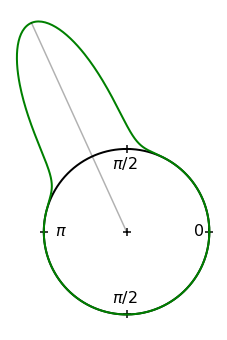

In [13]:
# PDF grid 
t = np.linspace(0,2*np.pi,1000, endpoint=False)
# PDF parameters 
mu = 2.
kappa = 20

# The PDF 
pdf = pdf_von_Mises(t,mu,kappa)

# Plot the PDF on a circle 
fig = plt.figure(figsize=(8,6))
plot_angular_density(t,pdf,colour="green",maxline=True)

# Save it
plt.savefig("vm-ang-density.png")

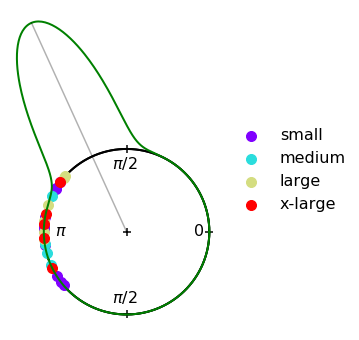

In [14]:
# Use the two plots together 
fig = plt.figure(figsize=(8,6))
plot_angular_density(t,pdf,colour="green",maxline=True)
plot_angular_scatter(t_samples,labels)

# Legend
plt.legend(frameon=False,loc="center left", bbox_to_anchor=(1,0.5), ncol=1,  fontsize=16)

# Save it
plt.savefig("vm-ang-scatter-density.png")

In [15]:
def polar_hist(samples, nbins,colour="blue",ax=None,label=None,grid=True,circle_radius=1,density=True):
    
    """
        polar_hist(samples, nbins,colour="blue",ax=None,label=None,grid=True,circle_radius=1,density=True)
        ==================================================================================================
        
        Creates a histogram of samples from a circular distribution and plots in on a circle.
        
        INPUT: 
        
            * samples - samples from a circular distribution, a scalar or array of floats. 
            * nbins - number of histogram bins. 
            * colour - an optional argument, the colour of the histogram. 
            * ax - an optional argument, ax is an axes object. Use ax to plot multiple polar histograms
            on the same set of axes.
            * label - an optional argument to pass a label for the data.
            * grid - an optional argument, whether or not to show the polar grid.
            * circle_radius - an optional argument, it is the radius on which the histogram is plotted. 
            If you choose density=True, you should accept the default of 1. However, if you set 
            density=False, you should manually select the radius depending on your data count. 
            * density - an optional argument, if true the normalised histogram is plotted, else the 
            count is used. 
            
        OUTPUT: 
        
            * A polar histogram plot is created. 
            * ax - the axes object on which the polar histogram was plotted. Use ax to plot multiple 
            polar histograms on the same set of axes.
            
    """
    
    # The polar axis
    if ax is None:
        ax = plt.axes(polar=True, frameon=False)

    # radius of inner circle
    bottom = circle_radius

    # theta grid
    theta = np.linspace(0.0, 2*np.pi, nbins, endpoint=False)

    # histogram bin heights and edges
    bin_heights, bin_edges = np.histogram(samples,bins=nbins,range=(0,2*np.pi),density=density)
    
    # height of radial bins 
    radii = bin_heights

    # bin width
    width = bin_edges[1] - bin_edges[0]

    # bar plot on polar axes 
    bars = ax.bar(theta, radii, width=width, bottom=bottom,color=colour, edgecolor='k',alpha=0.5,label=label)
    
    # polar grid
    if not grid:
        
        ax.grid(linewidth=2,color="black",alpha=0.5)
        ax.set_rgrids([0,bottom], angle=222,labels=[])
        ax.set_thetagrids([])
        
    else: 
        
        if density:
           
            radial = [0,0.5,1,1.5,2,2.5]
            radial_labels = [x - bottom for x in radial]    
            
        else: 
            
            mx = max(bin_heights)      
            radial = range(0,mx+int(bottom*2),int(bottom/2))
            radial_labels = [x - bottom for x in radial]

        # First two labels are inside the inner circle (bottom),
        # so remove them
        radial_labels[0] = ""
        radial_labels[1] = ""
        
        # Update to correct labels
        ax.set_rgrids(radial,labels=radial_labels)
        

    return ax

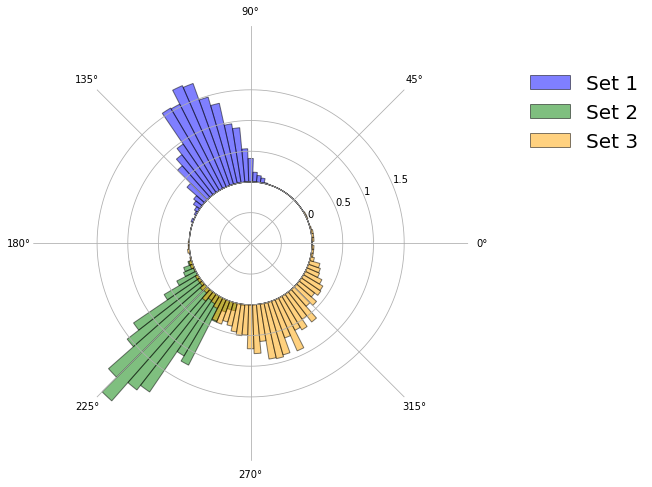

In [16]:
# Mock Data
# Number of data points
N = 1000

# Three sets of data
t_samples_1 = rand_von_Mises(N,mu=2,kappa=20)
t_samples_2 = rand_von_Mises(N,mu=4,kappa=30)
t_samples_3 = rand_von_Mises(N,mu=5,kappa=4)

# Plot the NORMALISED polar histograms of the three sets of data on the same set of axes
fig = plt.figure(figsize=(14,8))

# Set 1
ax=polar_hist(t_samples_1,nbins=100,colour="blue",label="Set 1",grid=True)

# Set 2
ax=polar_hist(t_samples_2,nbins=100,colour="green",ax=ax,label="Set 2",grid=True)

# Set 3
ax = polar_hist(t_samples_3,nbins=100,colour="orange",ax=ax,label="Set 3",grid=True)

# Legend    
plt.legend(frameon=False,loc="center left", bbox_to_anchor=(1.1, 0.8), ncol=1,  fontsize=20)  

# Save it
plt.savefig("vm-polar-hist-normalised.png")

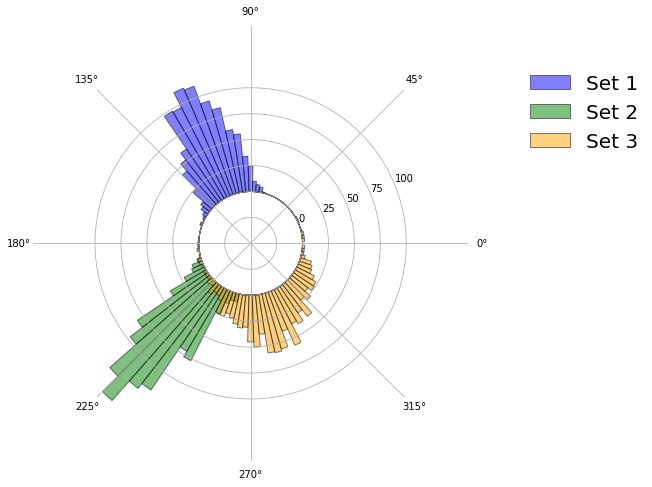

In [17]:
# Plot the polar histograms of the three sets of data on the same set of axes
fig = plt.figure(figsize=(14,8))

# Circle radius
cr = 50

# Set 1
ax=polar_hist(t_samples_1,nbins=100,colour="blue",label="Set 1",grid=True,density=False,circle_radius=cr)

# Set 2
ax=polar_hist(t_samples_2,nbins=100,colour="green",ax=ax,label="Set 2",grid=True,density=False,circle_radius=cr)

# Set 3
ax=polar_hist(t_samples_3,nbins=100,colour="orange",ax=ax,label="Set 3",grid=True,density=False,circle_radius=cr)

# Legend    
plt.legend(frameon=False,loc="center left", bbox_to_anchor=(1.1, 0.8), ncol=1,  fontsize=20)  

# Save it
plt.savefig("vm-polar-hist.png")

In [18]:
def plot_angular_density_3d(theta,pdf,colour="blue",axes="off",fs=16,label=None):
    
    """
        plot_angular_density_3d(theta,pdf,colour="blue",axes="off",fs=16)
        ============================================================================
        
        Plots the probability density function of a circular distribution on the unit 
        circle.
        
        INPUT: 
        
            * theta - angular grid - an array of floats. 
            * pdf - the values of the probability density function on the angular grid theta. 
            * colour - an optional argument, the colour of the pdf curve, a string. 
            * axes - an optional argument, whether or not to include the axes, boolean.
            * fs - an optional argument, the fontsize.
        
        OUTPUT: 
            
            * ax (axes) - Return axes of plot 
            * A plot on a circle of a circular distribution.
    
    """
    
    # Set projection
    ax = plt.axes(projection='3d')
    
    # Draw the unit circle 
    # ====================
    
    # Radius
    r = 1.0
    
    # Angular grid 
    ctheta = np.linspace(0,2*np.pi,500, endpoint=False)
    
    # Convert polar coordinates to cartesian coordinates
    [x,y] = polar2cartesian(r,ctheta)
    
    # Plot the unit circle 
    plt.plot(x,y,0,color='black',lw=2,zorder=0)
    
    # Draw angular probability density 
    # ================================
        
    # Convert polar coordinates to cartesian coordinates
    [xi,yi] = polar2cartesian(r,theta)
    
    z = pdf
    
    # Plot the PDF
    ax.plot(xi,yi,z,color=colour,lw=2,label=label)
    
    # Limits
    ax.set_xlim((-1,1))
    ax.set_ylim((-1,1))
    
    # Turn off grid 
    ax.grid(False)
    
    # Labels 
    ax.set_xlabel('x',fontsize=fs)
    ax.set_ylabel('y',fontsize=fs)
    ax.set_zlabel('z',fontsize=fs)
    ax.zaxis.set_rotate_label(False)
    
    # Ticks 
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    
    return ax

<IPython.core.display.Javascript object>


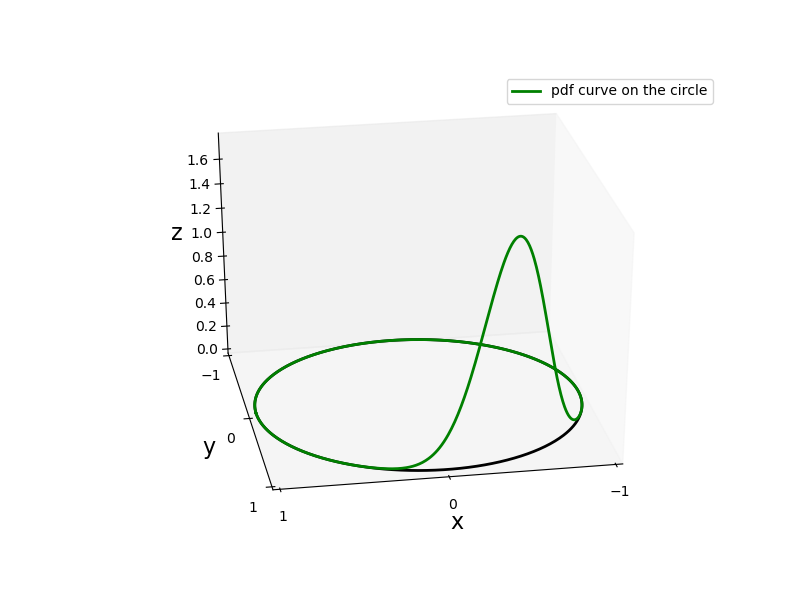

In [19]:
# PDF grid 
%matplotlib notebook
t = np.linspace(0,2*np.pi,1000, endpoint=False)
# PDF parameters 
mu = 2.
kappa = 20

# The PDF 
pdf = pdf_von_Mises(t,mu,kappa)

# Plot the PDF on a circle 
fig = plt.figure(figsize=(8,6))
ax=plot_angular_density_3d(t,pdf,colour="green",label='pdf curve on the circle')
ax.legend()

# # Draw a centre point
# ax.scatter([0], [0], [0], color="k", s=10)
# # Draw line in the mean direction 
# ax.plot([0,np.cos(mu)],[0,np.sin(mu)],0,color="k")
# ax.scatter( [np.cos(mu)], [np.sin(mu)], [0], color="k", s=10)

# View 
ax.view_init(30,80)

# Save it
plt.savefig("vm-ang-density_3d.png")

## References

   1. Von Mises, R., Uber die 'Ganzzahligkeit' der Atomgewichte und verwandte Fragen, Physikalische Zeitschrift, 19, 490--500, (1918).
 
<!-- @Article{ja:VonMises1918,
  author  = {Von Mises, R.},
  title   = {{Uber die 'Ganzzahligkeit' der Atomgewichte und verwandte Fragen}},
  journal = {Physikalische Zeitschrift},
  year    = {1918},
  volume  = {19},
  pages   = {490-500},
  note    = {cited By 158},
  source  = {Scopus},
} -->
 

   2. Best, D. J.  and Fisher, N. I. , Efficient Simulation of the von-Mises Distribution, J. Appl. Stat.,28, 152--157, (1979).

<!-- @Article{Best:1979:ESM,
  author          = {D. J. Best and N. I. Fisher},
  title           = {Efficient Simulation of the {von Mises} Distribution},
  journal         = j-APPL-STAT,
  year            = {1979},
  volume          = {28},
  number          = {2},
  pages           = {152--157},
  issn            = {0035-9254 (print), 1467-9876 (electronic)},
  acknowledgement = {#ack-nhfb#},
  bibdate         = {Sat Apr 21 10:22:32 MDT 2001},
  bibsource       = {http://www.math.utah.edu/pub/tex/bib/as1970.bib; JSTOR database},
  classcodes      = {C1140Z (Other topics in statistics)},
  coden           = {APSTAG},
  corpsource      = {CSIRO Div. of Math. and Statistics, North Ryde, NSW, Australia},
  fjournal        = {Applied Statistics},
  journal-url     = {http://onlinelibrary.wiley.com/journal/10.1111/(ISSN)1467-9876/issues},
  keywords        = {simulation; statistical analysis; von Mises distribution},
  treatment       = {A Application; T Theoretical or Mathematical},
} -->
    
   3. Fisher, N. I., Statistical Analysis of Circular Data, , Cambridge University Press, (1993)
    
<!-- @Book{fisher_1993,
  title     = {Statistical Analysis of Circular Data}
  publisher = {Cambridge University Press},
  year      = {1993},
  author    = {Fisher, N. I.},
  doi       = {10.1017/CBO9780511564345},
  place     = {Cambridge},
} -->
 

